# Assignment 5: Regularized Models

# /20 Marks

### Instructions

* Write your code in the cells provided.  Where appropirate, enter markdown to answer questions.
* Delete your output before submitting and ensure that the code works when executed sequentially
* Submit this notebook to OWL.

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
pd.set_option('display.max_columns', 500)

%matplotlib inline



# You're Still a Data Scientist!

Your models from the last assignment really impressed some in the management in your football club. Now that you have learned the art of regularization, your boss thinks you should do equally well with much less data. This will safe a lot of money the next time around. This time you get only a data set with 3000 observations.

This assignment can be done in a straightforward fashion by using sklearn model pipelines.  I suggest you read the documentation found below:

[Pipeline Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

[Pipeline Blog Post](https://towardsdatascience.com/a-simple-example-of-pipeline-in-machine-learning-with-scikit-learn-e726ffbb6976)

[GridSearh Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

### Question1: Preprocessing (1pt)

To get started repeat the preprocessing steps from last time: 
* Drop the variables: 'ID','club','club_logo','flag', 'nationality','photo','potential', 'birth_date'
* Dummy code the variables: work_rate_att, work_rate_def, preferred_foot. **Because we are running a regularized model, we do not want to drop the first column**
* Get a test data set of size 500 - to make results comparable to solutions, set random_state = 0

To make sure that you get a good start - check the solutions from Assignment 4. And make sure you can apply these steps flexibly and quickly. **You will need it for the midterm!**

In [89]:
df = pd.read_csv("footballer_small.csv")
print(df.shape)
model_data = df.drop(['ID','club','club_logo','flag', 'nationality','photo','potential', 'birth_date'],axis = 'columns')

model_data = model_data.drop(model_data.columns[0] , axis = 'columns')
model_data['work_rate_att'] = pd.Categorical(model_data.work_rate_att, categories=['Low','Medium','High'])
model_data['work_rate_def'] = pd.Categorical(model_data.work_rate_def, categories=['Low','Medium','High'])
model_data['preferred_foot'] = pd.Categorical(model_data.preferred_foot, categories = ['Left','Right'])
model_data = pd.get_dummies(model_data, drop_first=False)
Y = model_data.overall
X= model_data.drop("overall", axis = "columns")
Train_x,Test_x,Train_y,Test_y = train_test_split(X,Y,test_size = 500,random_state = 0)
print(Train_x.shape,Test_x.shape)



(3000, 53)
(2500, 48) (500, 48)


Question 2: Build a pipeline to preprocess the data (2pt)
To run the regression model, we want to have a design matrix which houses standardized features (that is, subtracts their means and divides by their standard deviations) and no intercept.

The Senior Data Scientist has asked you to build a pipeline to perform these actions. In your model pipeline, set ride regression's penalization parameter to 0.5. Do so and then visualize the first 50 rows of your design matrix using matplotlib.pyplot.imshow.


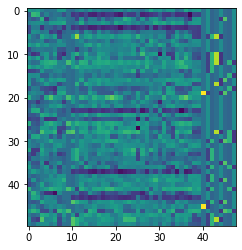

In [90]:
ridge_model= Pipeline([
        
      ("stard",StandardScaler(with_mean=True, with_std=True)),
      ("ridge",Ridge(alpha=0.5,fit_intercept=True))
       
        
])
scaler = StandardScaler(with_mean = True, with_std = True)
std_feature_X = scaler.fit_transform(X)
plt.imshow(std_feature_X[:50,:])




### Question 3: Do ridge regression (2pt)
Now use Ridge regression with a ridge parameter of 0.5 and report the Validation error on the training set. Use 10-fold cross-validation.  

In [91]:

ridge_model.fit(Train_x,Train_y)
cross_val = cross_val_score(ridge_model,
                               Train_x,
                               Train_y,
                               cv = 10,
                               scoring='neg_mean_squared_error'
                               )
print(cross_val)
cv_score_mean = -cross_val.mean()
print(cv_score_mean)





[-6.46920377 -6.6779953  -6.41042042 -6.01241783 -5.92307525 -6.00657911
 -5.61346857 -5.43737544 -5.40783257 -5.18738542]
5.914575367646265


### Question 4: Test Error (3pt)
Now test how the ridge model, fitted to the whole training set, on how it performs on the Test data set. Because you wrote a pipeline to perform the preprocessing steps, you shouldn't have to worry about preprocessing the test data.


Report the mean squared error on the test data - along with the 95% confidencen interval, determined with the central limit theorem. What proportion of the variance in the test scores have you predicted (+ CI)? 

In [100]:
se = (ridge_model.predict(Test_x) - Test_y)**2
mse = np.mean(se)
print("the mse is ",mse)
sd = np.std(se)
conf_inv = mse + 1.96*sd*np.array([-1,1])/np.sqrt(len(se))
conf_inv
print("the confident interval is ",conf_inv)
rss = sum(se)
tss = sum((Test_y - np.mean(Test_y))**2)
rsq = 1 - rss/tss
print("the proportion can be predicted by model is",rsq)




the mse is  6.451153177980513
the confident interval is  [5.55134368 7.35096268]
the proportion can be predicted by model is 0.8748311749551932


### Question 5: Tune the ridge parameter (3pt)
Now use 10-fold CV on the training set to determine a good setting for the regularization coefficient. Perform the search in log-space, going from $\lambda = \exp(-8), \cdots, \exp(3)$ in steps of 15. Plot the mean squared error as a function of $log(\lambda)$. 

Written answer:  What does this tell you about regularization in this model? 

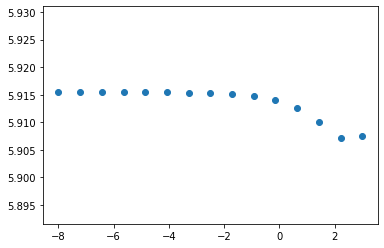

In [111]:
lam = np.exp(np.linspace(-8,3,15))
mse = np.zeros(15)

for i in range(lam.size):
    cv_scores = cross_val_score(ridge_model.set_params(ridge__alpha=lam[i]), Train_x, Train_y,cv=10,scoring = 'neg_mean_squared_error')
    mse[i]=-cv_scores.mean()

    

plt.scatter(np.log(lam),mse)


we can see that with increse of penalty parameter, first the mean error for cross validation decrease slowly at first, but when it pass some threshold, the mean error for cross validation increase. which means at first, model might have little bit overfitting, indroducing the penalty shrink the parameter value and reducing the testing error. but when it pass certain point, the model become lack of fitting and the bias increase dominating over the decrease of varience so overall tesing error increase.

### Question 6: Ridge regression with a more complex model - containing all 2-nd order interactions (2pt)
Give how well the model with all quadratic interactions worked the last time, your boss now wants to see if you can fit this model with all quadratic interaction terms to the data. 
Build a design matrix with all quadratic terms and 2-way interactions and then standardize them.  You can very easily do this by altering your pipeline.

Check how many regressors you have. Explain why you have this many terms. 

In [112]:
ridge_model_interaction= Pipeline([
       ('poly',PolynomialFeatures(include_bias=False)),    
       ("stard",StandardScaler(with_mean=True, with_std=True)),
       ("ridge",Ridge(alpha=0.5,fit_intercept=True))
        
])


poly = PolynomialFeatures(include_bias=False)
newdata = poly.fit_transform(X)

newdata.shape




(3000, 1224)

we have 1224 type of fit. 
 we can easily derive that the formula for polynomial features 0.5*n^2 +1.5n and plug n = 48 and get we have 1224 terms in total.


### Question 7: Tune the Ridge coefficient for the 2nd-order model   (3pt)
Now use 10-fold CV on the training set to determine a good setting for the regularization coefficient. Perform the search in log-space, going from $\lambda = \exp(-8), \cdots, \exp(3)$ in steps of 15. Plot the mean squared error as a function of $log(\lambda)$. 

Written answer: What does the shape of the curve (as compared to the answer to Question 5) tell you about this model? What is the best regularization? 

[9.15486758]


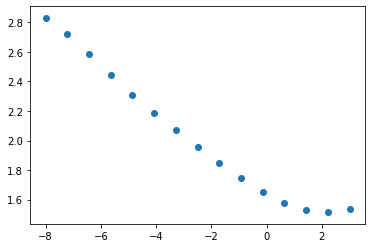

In [116]:

for i in range(lam.size):
    cv_scores = cross_val_score(ridge_model_interaction.set_params(ridge__alpha=lam[i]), Train_x, Train_y,cv=10,scoring = 'neg_mean_squared_error')
    mse[i]=-cv_scores.mean()

    

plt.scatter(np.log(lam),mse)

min_lam = lam[mse==np.min(mse)]
print(min_lam)



the shape decrease more dramaticly as increase of penalty at first place compared with curve in question 5, which means that the overfitting is serious at first place(it make sense because we use 2nd -order model). after pass a threshold, it show similiar trend with quesiton 5, increase slowly. the best regularization is $\lambda = 9.15486758


### Question 8: Test error  (2pt)
Report proportion of variance predicted + the 95% confidence for the 2nd-order model with the best regularization parameter, when you fit it on the entire training set. 




In [125]:

opti_model = ridge_model_interaction.set_params(ridge__alpha = min_lam).fit(Train_x, Train_y)
pred_y = opti_model.predict(Test_x)
se = (Test_y - pred_y)**2
sd = np.std(se)
mse1 = np.mean(se)
rss = np.sum((Test_y - pred_y)**2)
tss = np.sum((Test_y  - np.mean(Test_y ))**2)
conf_inv = mse1 + 1.96*sd*np.array([-1,1])/np.sqrt(len(se))
print("the confidence interval for mse is", conf_inv)
rsq = 1 - rss/tss 
print("the proportion of varience can be explained by model is",rsq)









the confidence interval for mse is [1.38051345 2.0240278 ]
the proportion of varience can be explained by model is 0.9669716082516405


### Question 9: Fine-tuning (2 pt)
That's pretty impressive! 

Now, your boss thinks that you could slightly improve your test error by fine-tuning your ridge parameter on the test set for the full model fit. Your boss instructs you to combine the training and test sets, refit the model, and then re-test on the test set.

Would you predict that a smaller or bigger regularization factor would do better? What do you think of this procedure? Is this a reliable procedure for assessing model fit?  Answer in no more than 5 sentences.

i think the smaller regularization factor would do better, because we have more datapoint on training. i think this procedure is useless.because we already incorporate the test data and use it to train the model, so we can't use this portion of data to test and evaluate the how well the model fit.

---
* Write your code in the cells provided.  Where appropirate, enter markdown to answer questions.
* Delete your output before submitting and ensure that the code works when executed sequentially
* Submit this notebook to OWL.